# Notebook to learn Foscat

This is based on demo.py written by Jean-Marc.
I have introduced the scattering covariance coefficients.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from importlib import reload

import foscat.FoCUS as FOC

import almscat.Sphere_lib as sphlib

2023-01-11 10:16:30.175331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-11 10:16:30.409837: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-11 10:16:30.409856: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-11 10:16:31.322854: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Instructions for updating:
non-resource variables are not supported in the long term


# Get data

In [91]:
# DEFINE A PATH FOR scratch data
# The data are stored using a default nside to minimize the needed storage
scratch_path = '../data'
nout = 32  # NSIDE

In [92]:
# Function to reduce the data used in the FoCUS algorithm
def dodown(a, nout):
    nin = int(np.sqrt(a.shape[0] // 12))
    if nin == nout:
        return (a)
    return (np.mean(a.reshape(12 * nout * nout, (nin // nout) ** 2), 1))

Mean and STD: -0.000 and 1.000


<Figure size 1000x600 with 0 Axes>

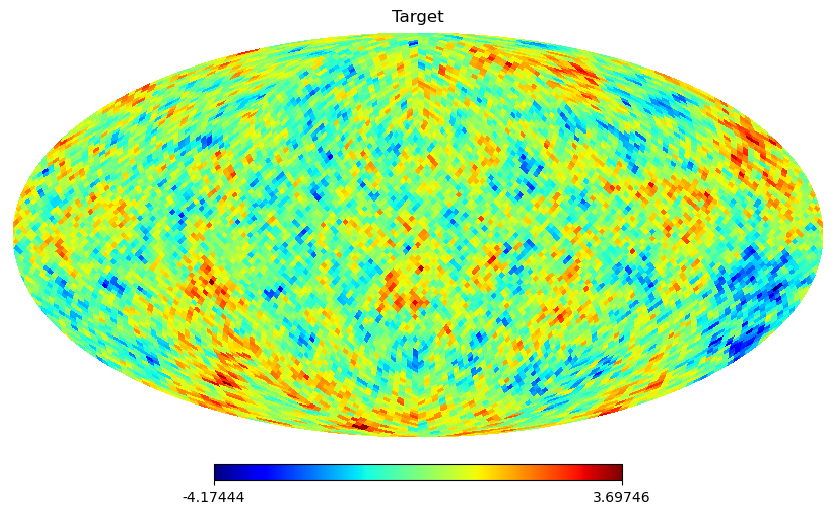

In [108]:
reload(sphlib)

##### Get data
# JM map
# im = dodown(np.load('example_JM/dust_64.npy'), nout)
# print(im.shape)

im = sphlib.make_hpx_sky(nside=nout, sky_type='cmb', normalize=True, nest=True)
# Planet map
# planet = 'venus'
# im = sphlib.make_hpx_planet(nside=256, planet=planet, interp=True, normalize=True, nest=True)
# np.save('/home/lmousset/Desktop/Venus_NSIDE32_Nested.npy', im)

# Plot the healpix map
plt.figure(figsize=(10, 6))
hp.mollview(im, cmap='jet', nest=True, title='Target')
# hp.mollview(im, cmap='jet', norm='hist', hold=False, nest=True, title='Target')
#
# im = dodown(themap, nout)
# plt.figure(figsize=(10, 6))
# hp.mollview(im, cmap='jet', nest=True, title='Target')

In [94]:
im

array([1.190892  , 0.98351926, 1.3800746 , ..., 1.1545825 , 2.0994205 ,
       1.4233207 ], dtype=float32)

 # Set masking to define the sky region of interest

In [95]:
# !!! No mask
nmasks = 1
mask=np.ones([1, 12*nout**2])

In [96]:
# 2 masks
# nin = 64
# tab = ['example_JM/MASK_GAL080_%d.npy' % (nin), 'example_JM/MASK_GAL060_%d.npy' % (nin)]  # Use 2 masks
# nmasks = len(tab)
# mask = np.ones([nmasks, 12 * nout ** 2])
# for i in range(nmasks):
#     mask[i, :] = dodown(np.load(tab[i]), nout)
# # force the first mask to be the all sky
# mask[0, :] = 1.

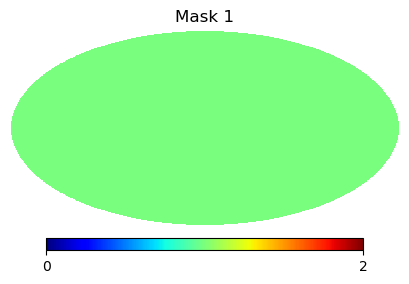

In [97]:
# Plot the masks
plt.figure()
for m in range (nmasks):
    hp.mollview(mask[m, :], cmap='jet', norm='hist', hold=False, sub=(2,1,m+1), nest=True, title=f'Mask {m+1}')

# INITIALIZE FoCUS class and synthesis

In [98]:
reload(FOC)

fc = FOC.FoCUS(NORIENT=4,  # define the number of wavelet orientation
               KERNELSZ=3,  # define the kernel size (here 3x3)
               healpix=True,  # use the healpix pixelisation
               OSTEP=0,  # get very large scale (nside=1)
               TEMPLATE_PATH=scratch_path)

# Add the masks
fc.add_mask(mask)

# compute amplitude to normalize the dynamic range
ampmap = 1 / im[mask[0] > 0.9].std()

# convert data in tensor for focus (should be done internally)
data = fc.convimage(ampmap * im)


Num GPUs Available:  0
==                                                        ==
==                                                        ==
==     RUN ON GPU Rank 0 : CPU:0                          ==
==                                                        ==
==                                                        ==
Use 1 masks


# COMPUTE THE WAVELET TRANSFORM

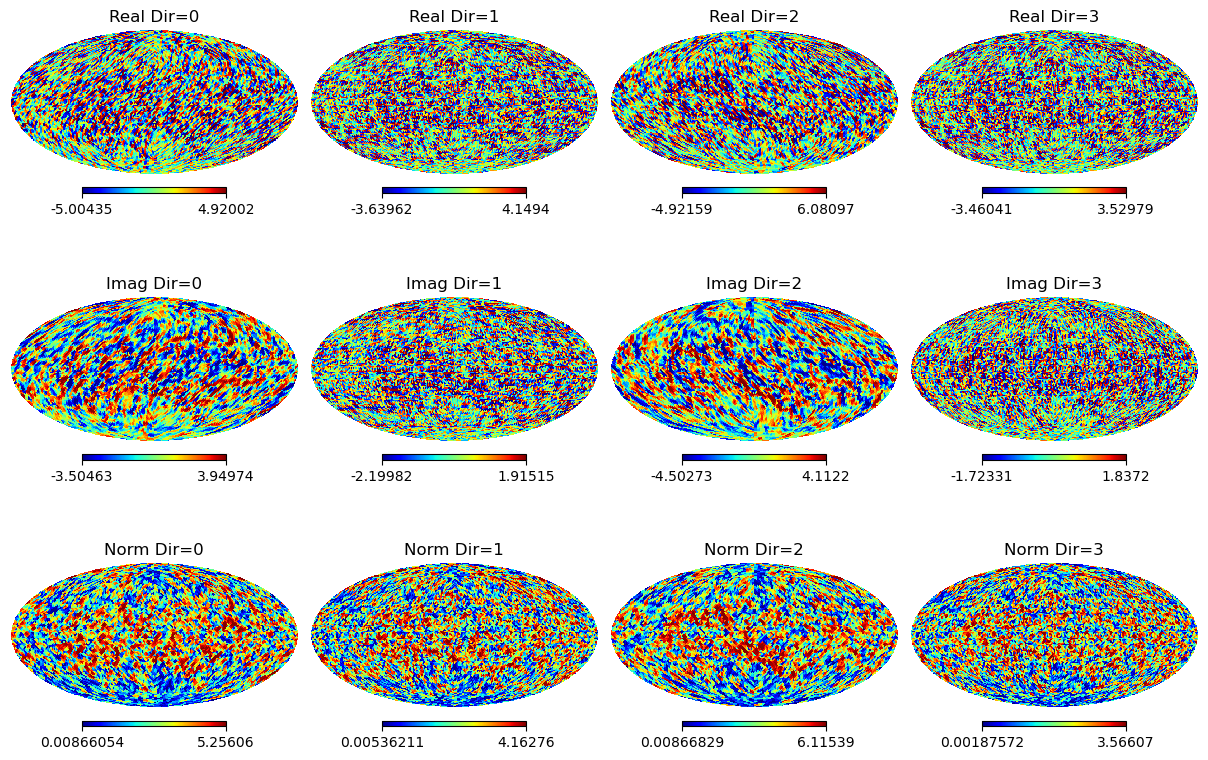

In [99]:
res = fc.do_conv(im)

plt.figure(figsize=(12, 8))
for i in range(4):
    hp.mollview(res[:, i].real, cmap='jet', hold=False, sub=(3, 4, 1 + i), nest=True, title='Real Dir=%d' % (i),
                norm='hist')
    hp.mollview(res[:, i].imag, cmap='jet', hold=False, sub=(3, 4, 5 + i), nest=True, title='Imag Dir=%d' % (i),
                norm='hist')
    hp.mollview(abs(res[:, i]), cmap='jet', hold=False, sub=(3, 4, 9 + i), nest=True, title='Norm Dir=%d' % (i),
                norm='hist')

# GET WAVELETS

And plot the 3x3 kernels

Real Part of the wavelet coefficients
[[-0.49105049  0.98210098 -0.49105049]
 [-1.00883043  2.01766086 -1.00883043]
 [-0.49105049  0.98210098 -0.49105049]]
Imaginary Part of the wavelet coefficients
[[-0.35676906 -0.          0.35676906]
 [-0.73295821  0.          0.73295821]
 [-0.35676906  0.          0.35676906]]


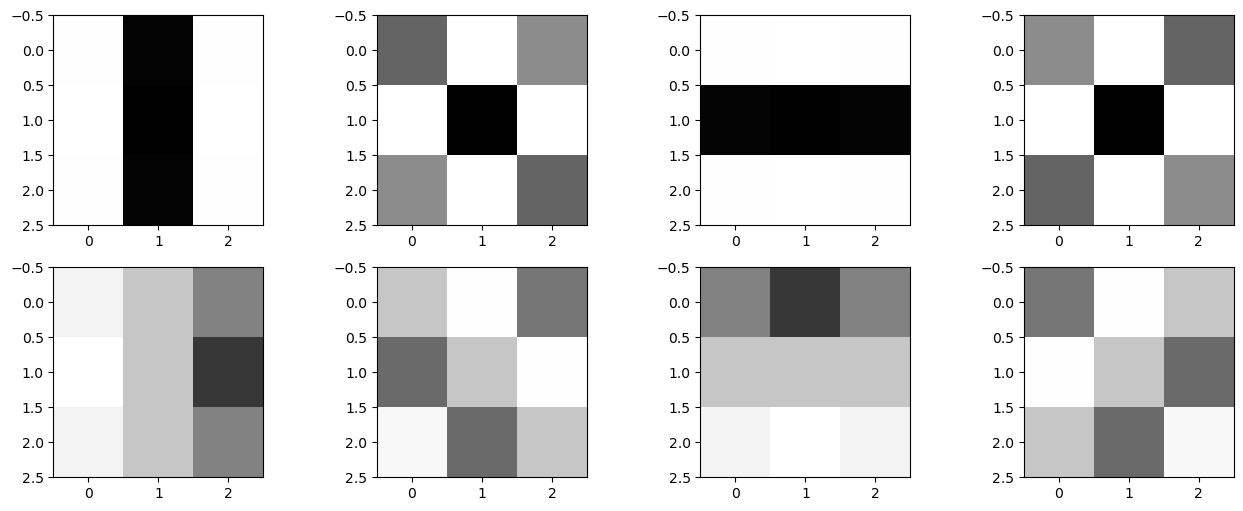

In [100]:
c, s = fc.get_ww()
kernel = int(np.sqrt(c.shape[0]))
print('Real Part of the wavelet coefficients')
print(c[:, 0].reshape(kernel, kernel))
print('Imaginary Part of the wavelet coefficients')
print(s[:, 0].reshape(kernel, kernel))
fc.plot_ww()


# Initialize the loss

In [101]:
# Initialize the learning and initialize the tensor to be synthesized
guess = np.random.randn(12 * nout * nout)  # Guess starting map (gaussian noise)
ldata = fc.init_synthese(guess)  # Tensor (guess map) [1, Npix, 1, 1]
print(ldata)


Initialize HEALPIX synthesis NSIDE= 32

 Npix_j3 = 12288, Nside_j3=32

 Npix_j3 = 3072, Nside_j3=16

 Npix_j3 = 768, Nside_j3=8

 Npix_j3 = 192, Nside_j3=4

 Npix_j3 = 48, Nside_j3=2
(1, 1, 5, 4) (1, 1, 5, 4) (1, 1, 20, 4, 4) (1, 1, 20, 4, 4, 4)
Tensor("sub_1579:0", shape=(1, 12288, 1, 1), dtype=float64, device=/device:CPU:0)


In [102]:
# J=6
# i=0
# for j3 in range(J):
#      for j2 in range(0, j3):
#          for j1 in range(0, j2):
#              i+=1
# print(i*2)

In [103]:
# Add losss:
# This computes the Scat coeffs of data and ldata
# We create the sigma and the bias as self of the class
fc.add_loss_cov(data, ldata)
print('====== Adding loss done ========')


 Npix_j3 = 12288, Nside_j3=32

 Npix_j3 = 3072, Nside_j3=16

 Npix_j3 = 768, Nside_j3=8

 Npix_j3 = 192, Nside_j3=4

 Npix_j3 = 48, Nside_j3=2
(1, 1, 5, 4) (1, 1, 5, 4) (1, 1, 20, 4, 4) (1, 1, 20, 4, 4, 4)

 Npix_j3 = 12288, Nside_j3=32

 Npix_j3 = 3072, Nside_j3=16

 Npix_j3 = 768, Nside_j3=8

 Npix_j3 = 192, Nside_j3=4

 Npix_j3 = 48, Nside_j3=2
(1, 1, 5, 4) (1, 1, 5, 4) (1, 1, 20, 4, 4) (1, 1, 20, 4, 4, 4)
====== Adding loss done ========


In [104]:
# initiliaze the loss
loss = fc.init_optim()

Initialized!


# Compute the scattering coefficients of the target

(1, 1, 1, 5, 4) (1, 1, 1, 5, 4) (1, 1, 1, 20, 4, 4) (1, 1, 1, 20, 4, 4, 4)


Text(0.5, 1.0, 'C11')

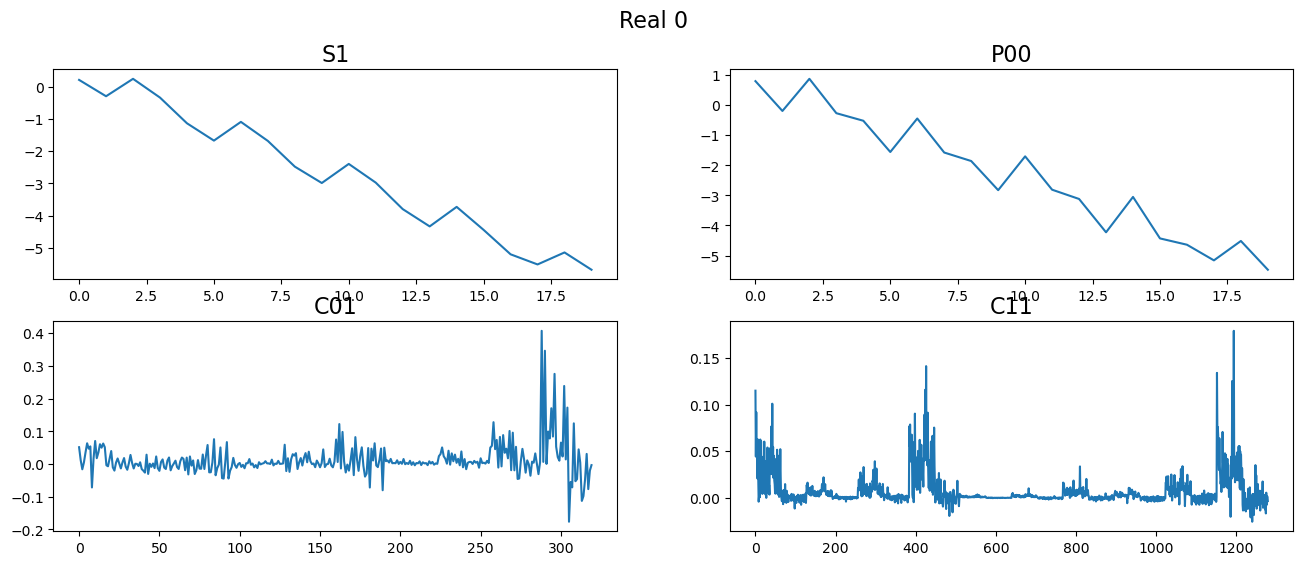

In [105]:
# # This function assumes you have several realisations. So the first dim must be the number of simulations. This is why we add a dimension to im
im_multi = im[None, :]
stat_S1, stat_P00, stat_C01, stat_C11 = fc.calc_stat_cov(im_multi * ampmap)
print(stat_S1.shape, stat_P00.shape, stat_C01.shape, stat_C11.shape)

r = 0 # Realisation index
fig, axs = plt.subplots(2, 2, figsize=(16, 6))
axs = axs.ravel()
fig.suptitle(f'Real {r}', fontsize=16)
axs[0].plot(stat_S1[r].flatten())
axs[0].set_title('S1', fontsize=16)
axs[1].plot(stat_P00[r].flatten())
axs[1].set_title('P00', fontsize=16)
axs[2].plot(stat_C01[r].flatten())
axs[2].set_title('C01', fontsize=16)
axs[3].plot(stat_C11[r].flatten())
axs[3].set_title('C11', fontsize=16)


# Run the synthesis

STEP 0 mLoss=     11.9 Loss=     11.9(    11.86) Lr=1 DT=7.66s


2023-01-11 12:00:59.986317: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] arithmetic_optimizer failed: INVALID_ARGUMENT: The graph couldn't be sorted in topological order.
2023-01-11 12:01:00.006858: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] remapper failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'mul_68442' -> 'gradients_21/mul_68444_grad/tuple/group_deps', 'mul_68440' -> 'gradients_21/mul_68444_grad/tuple/group_deps', 'mul_68441' -> 'gradients_21/mul_68444_grad/tuple/group_deps', 'gradients_21/Square_47_grad/Mul' -> 'mul_68443'}.
2023-01-11 12:01:00.027227: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:771] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2023-01-11 12:01:00.047922: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:771] Iteration = 1, topological sort failed with message: The graph couldn't be s

STEP 30 mLoss=     5.46 Loss=     5.46(     5.46) Lr=0.86 DT=25.70s
STEP 60 mLoss=    0.489 Loss=    0.489(    0.489) Lr=0.74 DT=0.89s
STEP 90 mLoss=    0.244 Loss=    0.244(   0.2438) Lr=0.637 DT=0.90s
STEP 120 mLoss=    0.172 Loss=    0.172(   0.1715) Lr=0.548 DT=0.89s
STEP 150 mLoss=    0.142 Loss=    0.142(   0.1416) Lr=0.471 DT=0.88s
STEP 180 mLoss=    0.124 Loss=    0.124(    0.124) Lr=0.406 DT=0.88s
STEP 210 mLoss=    0.112 Loss=    0.112(   0.1123) Lr=0.349 DT=0.87s
STEP 240 mLoss=    0.104 Loss=    0.104(   0.1037) Lr=0.3 DT=0.87s
STEP 270 mLoss=   0.0971 Loss=   0.0971(  0.09707) Lr=0.258 DT=0.86s
STEP 299 mLoss=    0.092 Loss=    0.092(  0.09203) Lr=0.223 DT=0.84s
STEP 0 mLoss=   0.0919 Loss=   0.0919(  0.09187) Lr=1 DT=0.01s
STEP 30 mLoss=   0.0755 Loss=   0.0755(  0.07553) Lr=0.86 DT=0.85s
STEP 60 mLoss=   0.0658 Loss=   0.0658(   0.0658) Lr=0.74 DT=0.88s
STEP 90 mLoss=   0.0594 Loss=   0.0594(  0.05937) Lr=0.637 DT=0.88s
STEP 120 mLoss=   0.0548 Loss=   0.0548(  0.05475) 

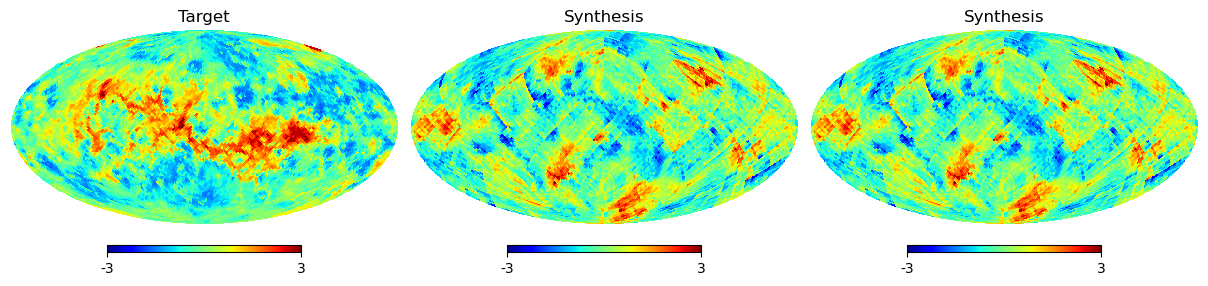

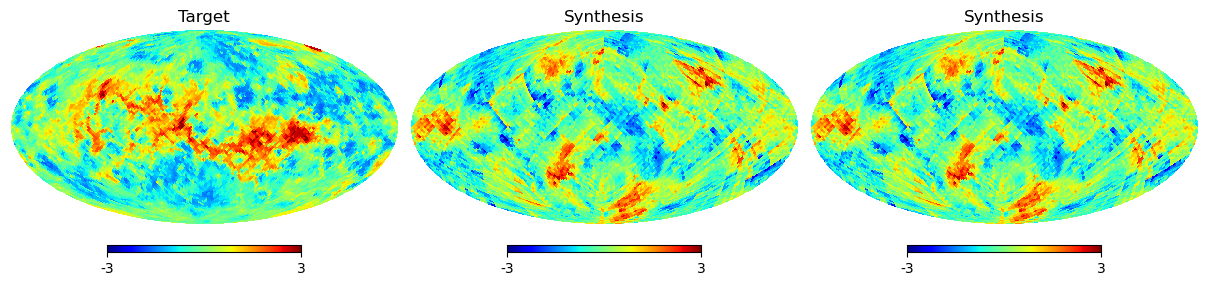

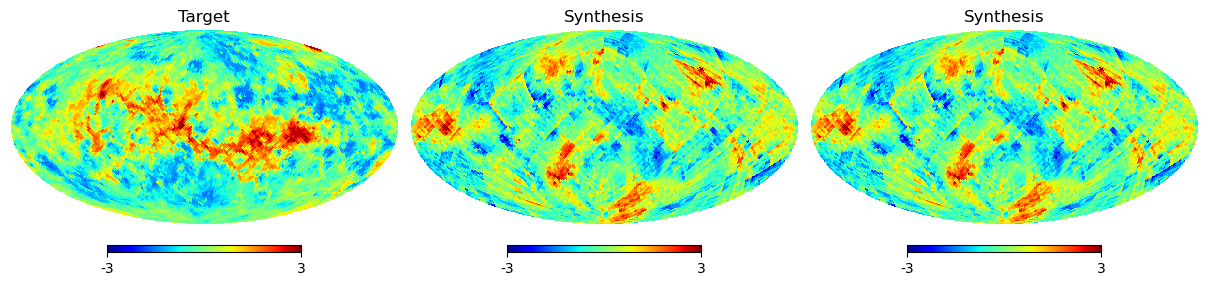

In [106]:
# define BIAS and WEIGTH for each scaterring coefficients
tw1, tw2, tw3, tw4 = {}, {}, {}, {}
tb1, tb2, tb3, tb4 = {}, {}, {}, {}

# Sigma: 1. with the coeff shape
tw1[0] = np.ones_like(stat_S1[0])
tw2[0] = np.ones_like(stat_P00[0])
tw3[0] = np.ones_like(stat_C01[0])
tw4[0] = np.ones_like(stat_C11[0])
# tw1[0] = 1. / stat_S1[0]
# tw2[0] = 1. / stat_P00[0]
# tw3[0] = 1. / stat_C01[0]
# tw4[0] = 1. / stat_C11[0]

# Bias: 0. with the coeff shape
tb1[0] = np.zeros_like(stat_S1[0])
tb2[0] = np.zeros_like(stat_P00[0])
tb3[0] = np.zeros_like(stat_C01[0])
tb4[0] = np.zeros_like(stat_C11[0])

# fc.reset()
omap_list = []
for i in range(3):
    result = fc.learn(tw1, tw2, tb1, tb2,
                    NUM_EPOCHS=300,    # Number of iterations
                    EVAL_FREQUENCY=30, # Frequency at which the loss is evaluated.
                    DECAY_RATE=0.995,
                    LEARNING_RATE=1.,
                    SEQUENTIAL_ITT=10,
                    ADDAPT_LEARN=200.0,
                    IW3=tw3,
                    IW4=tw4,
                    IB3=tb3,
                    IB4=tb4
                    )
    plt.figure(figsize=(12, 4))
    hp.mollview(im, cmap='jet', hold=False, sub=(1, 3, 1), nest=True, title='Target', min=-3, max=3)
    # hp.mollview(im[idx],cmap='jet',norm='hist',hold=False,sub=(2,1,2),nest=False)
    hp.mollview(result, cmap='jet', hold=False, sub=(1, 3, 2), nest=True, title='Synthesis', min=-3, max=3)
    hp.mollview(fc.get_map(), cmap='jet', hold=False, sub=(1, 3, 3), nest=True, title='Synthesis', min=-3, max=3)

    omap_list.append(result)


# Control the synthesis

#### Look at the maps


IndexError: list index out of range

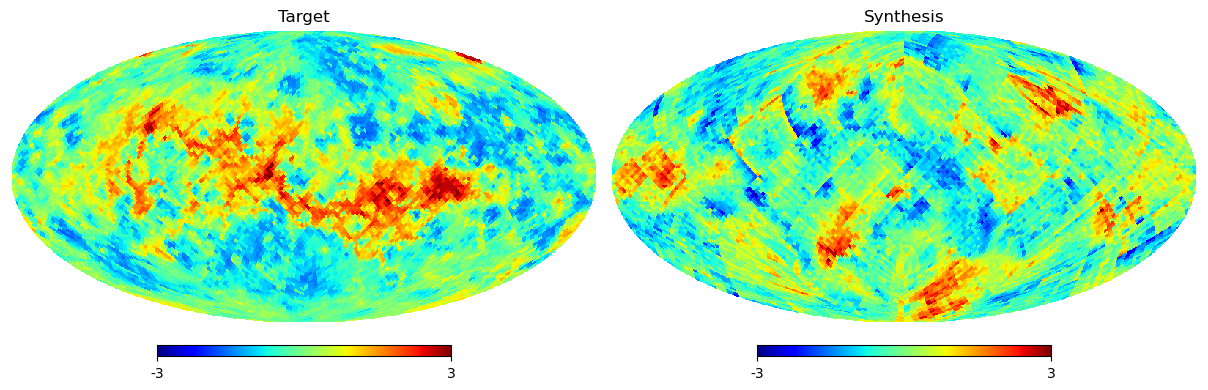

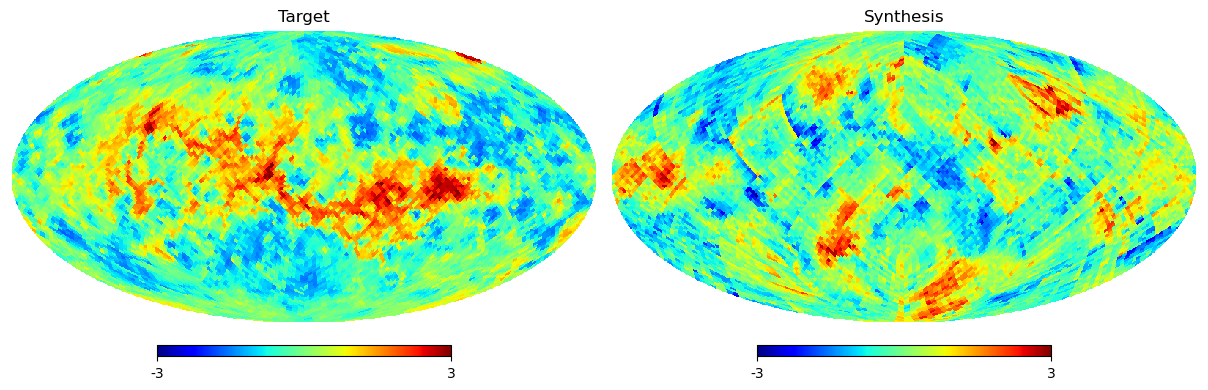

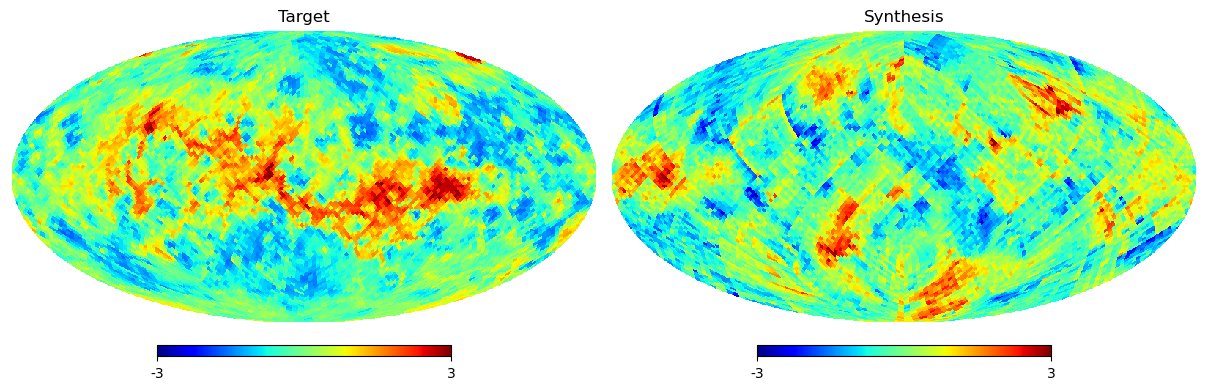

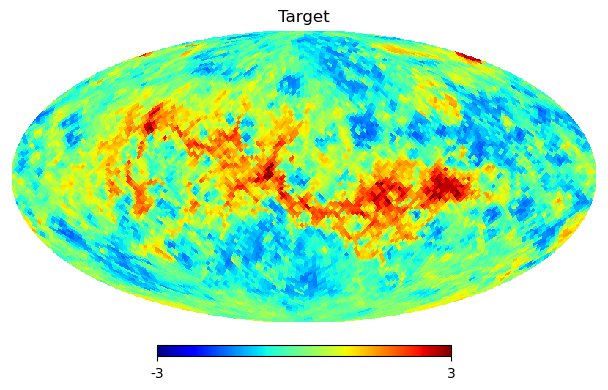

In [107]:
# omap = fc.get_map()
omap = omap_list[-1]

for idx in range(6):
    plt.figure(figsize=(12, 4))
    hp.mollview(im, cmap='jet', hold=False, sub=(1, 2, 1), nest=True, title='Target', min=-3, max=3)
    # hp.mollview(im[idx],cmap='jet',norm='hist',hold=False,sub=(2,1,2),nest=False)
    hp.mollview(omap_list[idx], cmap='jet', hold=False, sub=(1, 2, 2), nest=True, title='Synthesis', min=-3, max=3)

#### Look at the scattering coefficients

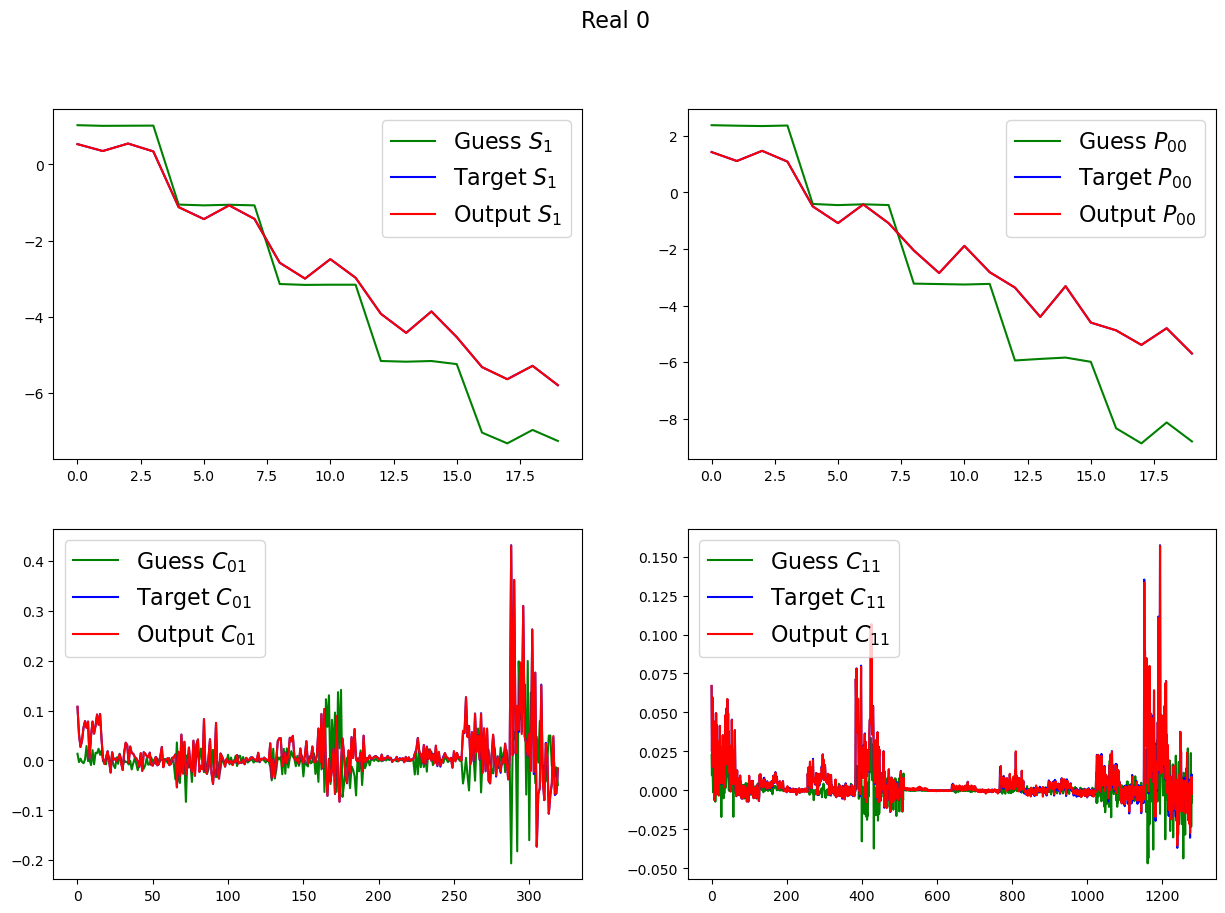

In [41]:
oS1, oP00, oC01, oC11 = fc.calc_stat_cov(omap[None, :])

S1guess, P00guess, C01guess, C11guess = fc.calc_stat_cov(guess[None, :])

r = 0  # Realisation
plt.figure(figsize=(15,10))
plt.suptitle(f'Real {r}', fontsize=16)
plt.subplot(2,2,1)
plt.plot(S1guess.flatten(), color='green',label=r'Guess $S_1$')
plt.plot(stat_S1[r].flatten(), color='blue',label=r'Target $S_1$')
plt.plot(oS1.flatten(),color='red',label=r'Output $S_1$')
# plt.yscale('log')
plt.legend(fontsize=16)

plt.subplot(2,2,2)
plt.plot(P00guess.flatten(), color='green',label=r'Guess $P_{00}$')
plt.plot(stat_P00[r].flatten(), color='blue',label=r'Target $P_{00}$')
plt.plot(oP00.flatten(),color='red',label=r'Output $P_{00}$')
# plt.yscale('log')
plt.legend(fontsize=16)

plt.subplot(2,2,3)
plt.plot(C01guess.flatten(), color='green',label=r'Guess $C_{01}$')
plt.plot(stat_C01[r].flatten(), color='blue',label=r'Target $C_{01}$')
plt.plot(oC01.flatten(),color='red',label=r'Output $C_{01}$')
# plt.yscale('log')
plt.legend(fontsize=16)

plt.subplot(2,2,4)
plt.plot(C11guess.flatten(), color='green',label=r'Guess $C_{11}$')
plt.plot(stat_C11[r].flatten(), color='blue',label=r'Target $C_{11}$')
plt.plot(oC11.flatten(),color='red',label=r'Output $C_{11}$')
# plt.yscale('log')
plt.legend(fontsize=16)


#### Angular power spectrum

Text(0, 0.5, '$C_\\ell$')

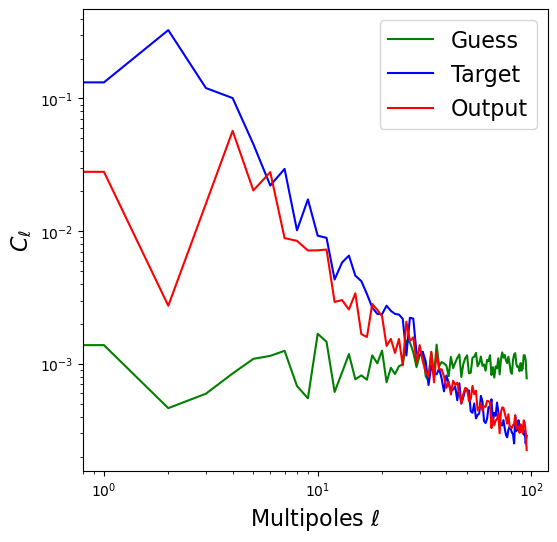

In [141]:
idx=hp.ring2nest(nout, np.arange(12*nout**2))

# clguess = hp.anafast((guess)[idx])
# cli = hp.anafast((im)[idx])
# clo = hp.anafast((omap)[idx])

clguess = hp.anafast((guess - np.median(guess))[idx])
cli = hp.anafast((im - np.median(im))[idx])
clo = hp.anafast((omap - np.median(omap))[idx])
# cli=hp.anafast((im*mask[0]-np.median(im*mask[0]))[idx])
# clo=hp.anafast((omap*mask[0]-np.median(omap*mask[0]))[idx])

plt.figure(figsize=(6,6))
plt.plot(clguess,color='green',label=r'Guess')
plt.plot(cli,color='blue',label=r'Target')
plt.plot(clo,color='red',label=r'Output')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=16)
plt.xlabel(r'Multipoles $\ell$', fontsize=16)
plt.ylabel(r'$C_\ell$', fontsize=16)

### Plot the histogram

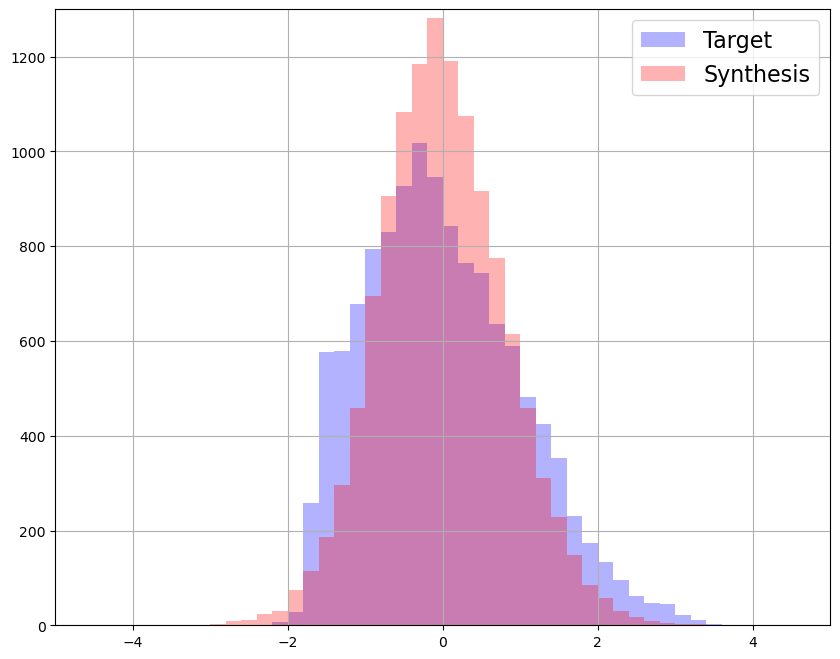

In [142]:
def plot_histo(target_hpx, synthetic_hpx, bins=50, range=(-5, 5), ymax=1300, fontsize=16):
    plt.figure(figsize=(10, 8))
    plt.hist(target_hpx.ravel(), bins=bins, range=range, color='b', alpha=0.3, label='Target')
    plt.hist(synthetic_hpx.ravel(), bins=bins, range=range, color='r', alpha=0.3, label='Synthesis')
    plt.legend(fontsize=fontsize)
    plt.ylim(0, ymax)
    plt.xlim(range)
    plt.grid()
    return

plot_histo(im, omap)

#### Plot the loss

(153,)


Text(0, 0.5, 'Loss')

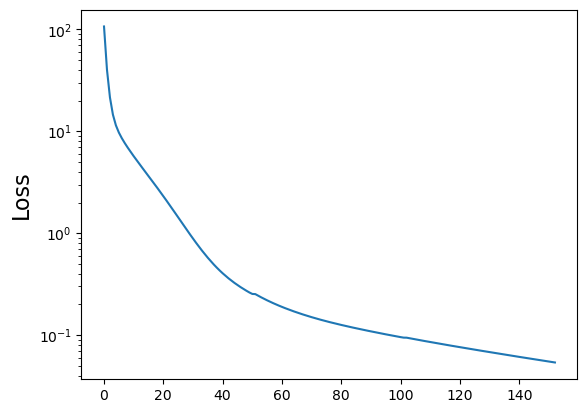

In [143]:
loss = fc.get_log()
print(loss.shape)

# Plot the loss
plt.figure()
plt.plot(loss[:])
plt.yscale('log')
plt.ylabel('Loss', fontsize=16)

# Test code JM

Num GPUs Available:  0
==                                                        ==
==                                                        ==
==     RUN ON GPU Rank 0 : CPU:0                          ==
==                                                        ==
==                                                        ==
Use 1 masks
Initialize HEALPIX synthesis NSIDE= 32

 Npix_j3 = 12288, Nside_j3=32

 Npix_j3 = 3072, Nside_j3=16

 Npix_j3 = 768, Nside_j3=8

 Npix_j3 = 192, Nside_j3=4

 Npix_j3 = 48, Nside_j3=2
(1, 1, 5, 4) (1, 1, 5, 4) (1, 1, 20, 4, 4) (1, 1, 20, 4, 4, 4)
Real Part of the wavelet coefficients
[[-0.49105049  0.98210098 -0.49105049]
 [-1.00883043  2.01766086 -1.00883043]
 [-0.49105049  0.98210098 -0.49105049]]
Imaginary Part of the wavelet coefficients
[[-0.35676906 -0.          0.35676906]
 [-0.73295821  0.          0.73295821]
 [-0.35676906  0.          0.35676906]]

 Npix_j3 = 12288, Nside_j3=32

 Npix_j3 = 3072, Nside_j3=16

 Npix_j3 = 768, Nside_j3=8

 Npix_j

2023-01-11 11:56:23.266667: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] arithmetic_optimizer failed: INVALID_ARGUMENT: The graph couldn't be sorted in topological order.
2023-01-11 11:56:23.283793: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] remapper failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'mul_61645' -> 'gradients_19/mul_61647_grad/tuple/group_deps', 'mul_61643' -> 'gradients_19/mul_61647_grad/tuple/group_deps', 'mul_61644' -> 'gradients_19/mul_61647_grad/tuple/group_deps', 'gradients_19/Square_43_grad/Mul' -> 'mul_61646'}.
2023-01-11 11:56:23.299267: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:771] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2023-01-11 11:56:23.314761: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:771] Iteration = 1, topological sort failed with message: The graph couldn't be s

STEP 100 mLoss=    0.137 Loss=    0.137(   0.1366) Lr=0.74 DT=25.08s
STEP 200 mLoss=   0.0741 Loss=   0.0741(  0.07414) Lr=0.548 DT=2.80s
STEP 299 mLoss=   0.0591 Loss=   0.0591(  0.05906) Lr=0.407 DT=2.73s
STEP 0 mLoss=    0.059 Loss=    0.059(  0.05896) Lr=1 DT=0.01s
STEP 100 mLoss=   0.0438 Loss=   0.0438(  0.04378) Lr=0.74 DT=2.77s
STEP 200 mLoss=   0.0367 Loss=   0.0367(  0.03671) Lr=0.548 DT=2.76s
STEP 299 mLoss=   0.0328 Loss=   0.0328(  0.03278) Lr=0.407 DT=2.73s
STEP 0 mLoss=   0.0328 Loss=   0.0328(  0.03275) Lr=1 DT=0.01s
STEP 100 mLoss=   0.0275 Loss=   0.0275(  0.02752) Lr=0.74 DT=2.68s
STEP 200 mLoss=   0.0247 Loss=   0.0247(  0.02469) Lr=0.548 DT=2.69s
STEP 299 mLoss=   0.0229 Loss=   0.0229(  0.02292) Lr=0.407 DT=2.66s


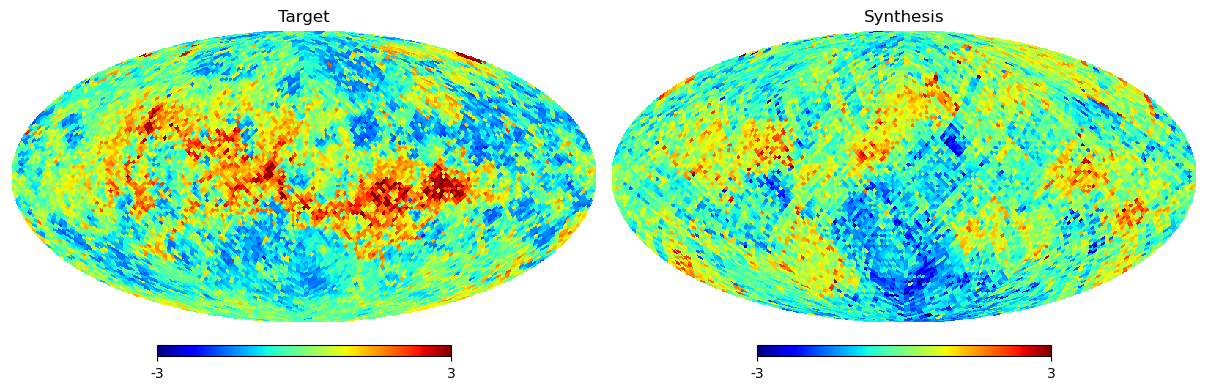

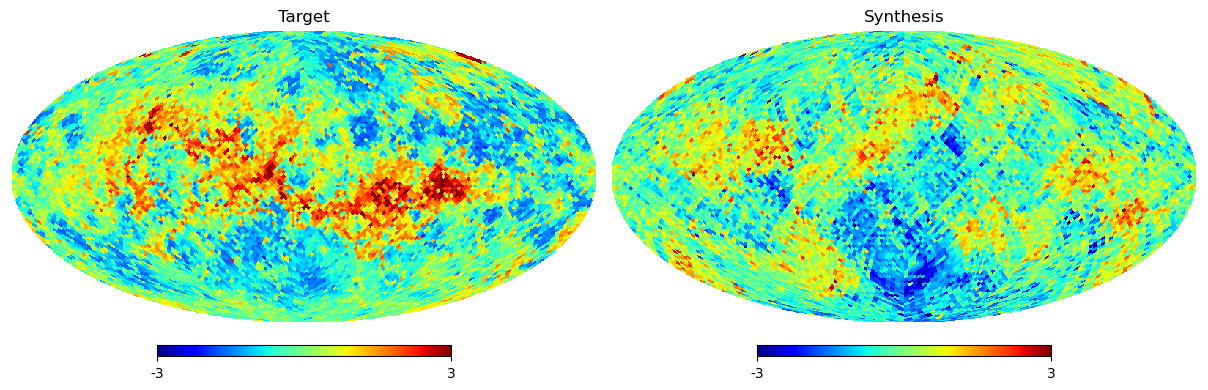

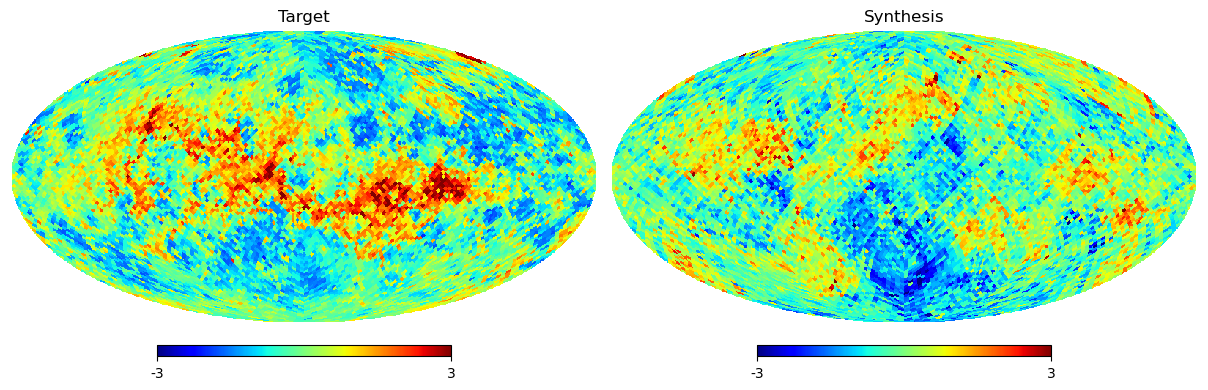

In [89]:
#=================================================================================
# DEFINE A PATH FOR scratch data
# The data are storred using a default nside to minimize the needed storage
#=================================================================================
scratch_path = '../data'
outname='TEST_EE'
nout=32
#=================================================================================
# Function to reduce the data used in the FoCUS algorithm
#=================================================================================
def dodown(a,nout):
    nin=int(np.sqrt(a.shape[0]//12))
    if nin==nout:
        return(a)
    return(np.mean(a.reshape(12*nout*nout,(nin//nout)**2),1))
# #=================================================================================
# # Get data
# #=================================================================================
im=dodown(np.load('/home/lmousset/Desktop/Venus_NSIDE32_Nested.npy'),nout)

#=================================================================================
# INITIALIZE FoCUS class
#=================================================================================
fc=FOC.FoCUS(NORIENT=4,   # define the number of wavelet orientation
             KERNELSZ=3,  # define the kernel size (here 3x3)
             healpix=True, # use the healpix pixelisation
             OSTEP=0,     # get very large scale (nside=1)
             TEMPLATE_PATH=scratch_path)

mask=np.ones([1,12*nout**2])
fc.add_mask(mask)

#=============================================
# compute amplitude to normalize the dynamic range
ampmap=1/im[mask[0]>0.9].std()

# convert data in tensor for focus (should be done internally)
data = fc.convimage(ampmap*(im))

# Initialize the learning and initialize the tensor to be synthesized
ldata=fc.init_synthese(np.random.randn(12*nout*nout))

#=================================================================================
# GET WAVELET COEFFICIENTS
#=================================================================================
c,s=fc.get_ww()
kernel=int(np.sqrt(c.shape[0]))
print('Real Part of the wavelet coefficients')
print(c[:,0].reshape(kernel,kernel))
print('Imaginary Part of the wavelet coefficients')
print(s[:,0].reshape(kernel,kernel))
#fc.plot_ww()

# Add losss:
#fc.add_loss_healpix(data,data,ldata,ldata,imaginary=False)
fc.add_loss_cov(data,ldata)
# initiliaze the loss
loss=fc.init_optim()

#================================================================================
# End of the initialization
#================================================================================

#================================================================================
# Compute the S1 and S2 coefficients
#================================================================================

s1,s2,s3,s4=fc.calc_stat_cov(im.reshape(1,12*nout*nout)*ampmap)
r1,r2,r3,r4=fc.calc_stat_cov(fc.get_map().reshape(1,12*nout*nout))

#define BIAS and WEIGTH for each scaterring coefficients
tw1={}
tw2={}
tw3={}
tw4={}
tb1={}
tb2={}
tb3={}
tb4={}
for i in range(1):
    tw1[i]=1+0.0/(s1[0])
    tw2[i]=1+0.0/(s2[0])
    tw3[i]=1+0.0/(s3[0])
    tw4[i]=1+0.0/(s4[0])
    tb1[i]=0.0*s1[0]
    tb2[i]=0.0*s2[0]
    tb3[i]=0.0*s3[0]
    tb4[i]=0.0*s4[0]

for i in range(3):
    #================================================================================
    # Run the synthesis
    #================================================================================
    omap=fc.learn(tw1,tw2,tb1,tb2,
                  NUM_EPOCHS = 300,
                  EVAL_FREQUENCY = 100,
                  DECAY_RATE=0.997,
                  LEARNING_RATE=1.0,
                  SEQUENTIAL_ITT=10,
                  ADDAPT_LEARN=200.0,
                  IW3=tw3,IW4=tw4,
                  IB3=tb3,IB4=tb4)

    #================================================================================
    # store results
    #================================================================================
    modd1=omap.reshape(1,12*nout**2)
    os1,os2,os3,os4=fc.calc_stat_cov(modd1)

    plt.figure(figsize=(12, 4))
    hp.mollview(im, cmap='jet', hold=False, sub=(1, 2, 1), nest=True, title='Target', min=-3, max=3)
    # hp.mollview(im[idx],cmap='jet',norm='hist',hold=False,sub=(2,1,2),nest=False)
    hp.mollview(omap, cmap='jet', hold=False, sub=(1, 2, 2), nest=True, title='Synthesis', min=-3, max=3)